In [15]:
###     Imports             - Public Libraries
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
import multiprocessing as mp

from copy import deepcopy
from datetime import datetime
from tqdm import tqdm
from time import time
from statistics import mean, stdev

###     Imports             - User-Defined Files
from generic_agent import GenericAgent as Agent
from iam_models import distance

###     Results Dictionary Creation
results_dict = {}

## Simulation Function

In [16]:
"""         IMPORTANT PARAMETERS        """

###     Initializations     - Scalars
dim             =   3   # 2 or 3
num_agents      =   20
num_faulty      =   6   # must be << num_agents for sparse error assumption
n_scp           =   12  # Number of SCP iterations
n_admm          =   10  # Number of ADMM iterations
n_iter          =   n_admm * n_scp
use_threshold   =   False
pos_noise       =   0.02
warm_start      =   True


###     Initializations     - Simulation Variable Parameters
rho_opt = [0.25, 1.25]
iam_noise_opt = [0.02, 0.05]


###     Initializations     - Output Settings
show_prints     =   False
hide_tqdm       =   False
show_prob1      =   False
show_prob2      =   False


###     Initializations     - Agents
# 20 agents making up a complex 3d configuration
agents      =   [None] * num_agents
agents[0]   =   Agent(agent_id = 0, init_position = np.array([[0.1, 2.4, 5.4]]).T)
agents[1]   =   Agent(agent_id = 1, init_position = np.array([[2.8, 5.4, 6.1]]).T)
agents[2]   =   Agent(agent_id = 2, init_position = np.array([[2.15, 4.8, 4.3]]).T)
agents[3]   =   Agent(agent_id = 3, init_position = np.array([[1.15, 0.4, 3.9]]).T)
agents[4]   =   Agent(agent_id = 4, init_position = np.array([[3.0, 3.85, 5.4]]).T)
agents[5]   =   Agent(agent_id = 5, init_position = np.array([[3.4, 4.25, 2.0]]).T)
agents[6]   =   Agent(agent_id = 6, init_position = np.array([[3.45, 1.8, 2.2]]).T)
agents[7]   =   Agent(agent_id = 7, init_position = np.array([[5.2, 5.0, 5.25]]).T)
agents[8]   =   Agent(agent_id = 8, init_position = np.array([[5.3, 3.8, 0.1]]).T)
agents[9]   =   Agent(agent_id = 9, init_position = np.array([[5.2, 0.8, 3.15]]).T)
agents[10]  =   Agent(agent_id = 10, init_position = np.array([[6.2, 3.3, 5.6]]).T)
agents[11]  =   Agent(agent_id = 11, init_position = np.array([[5.05, 3.8, 3.6]]).T)
agents[12]  =   Agent(agent_id = 12, init_position = np.array([[4.15, 5.65, 3.4]]).T)
agents[13]  =   Agent(agent_id = 13, init_position = np.array([[0.15, 3.4, 2.45]]).T)
agents[14]  =   Agent(agent_id = 14, init_position = np.array([[1.85, 5.15, 0.65]]).T)
agents[15]  =   Agent(agent_id = 15, init_position = np.array([[2.4, 2.4, 1.6]]).T)
agents[16]  =   Agent(agent_id = 16, init_position = np.array([[1.4, 5.4, 2.4]]).T)
agents[17]  =   Agent(agent_id = 17, init_position = np.array([[3.2, 3.4, 0.2]]).T)
agents[18]  =   Agent(agent_id = 18, init_position = np.array([[5.4, 5.4, 1.4]]).T)
agents[19]  =   Agent(agent_id = 19, init_position = np.array([[4.7, 2.4, 5.4]]).T)

# Add error vector
faulty_id = [0, 5, 7, 9, 10, 13]
err_scaling = 1
fault_vec   =   [np.array([[0.275, 0.447, 0.130]]).T,
                np.array([[-0.849, 0.170, 0.888]]).T,
                np.array([[0.761, -0.408, 0.438]]).T,
                np.array([[-0.640, 0.260, -0.941]]).T,
                np.array([[0.879, 0.425, -0.710]]).T,
                np.array([[-0.534, -0.543, -0.588]]).T]
for index, agent_id in enumerate(faulty_id):
    agents[agent_id].faulty = True
    agents[agent_id].error_vector = fault_vec[index][:,np.newaxis].reshape((dim, -1))

x_true = []
for id, agent in enumerate(agents):
    x_true.append(agent.error_vector)


# Set Neighbors
edges       =  [[0,2], [0,3], [0,4], [0,16], 
                [1,2], [1,4], [1,7], [1,11],
                [2,4], [2,5], [2,7], [3,4],
                [4,5], [4,6], [4,7], [4,10],
                [5,6], [5,8], [6,7], [6,9],
                [7,10], [8,9], [8,11], [9,11],
                [9,10], [10,11], [12,5], [12,7],
                [12,11], [12,2], [13,14], [13,15],
                [14,15], [3,15], [5,15], [13,0],
                [14,5], [6,14], [19,10], [19,4],
                [19,9], [18,8], [18,17], [18,11],
                [18,12], [17,14], [17,15], [17,8],
                [17,18], [16,14], [16,2], [16,13],
                [18,5], [15,6], [16,3], [0,19],
                [7,19], [17,5]] 
edges_flip  =   deepcopy(edges)
for idx, dir_edge in enumerate(edges_flip):
    dir_edge.reverse()

edges       =   edges+edges_flip            # these edges are directed

for agent_id, agent in enumerate(agents):
    # Neighbor List
    nbr_list        =   []
    edge_list       =   []
    
    for edge_ind, edge in enumerate(edges):
        if (agent_id) == edge[0]:
            nbr_list.append(edge[1])
            edge_list.append(edge_ind)
    
    agent.set_neighbors(nbr_list)
    agent.set_edge_indices(edge_list)



###     Useful Functions

# Measurement function Phi
def measurements(p, x_hat):
    measurements = []

    for edge in edges:
        dist = distance((p[edge[0]] + x_hat[edge[0]]), (p[edge[1]] + x_hat[edge[1]]))
        measurements.append(dist)

    return measurements

# Finds row of R
def get_Jacobian_row(edge_ind, p, x):
    edge = edges[edge_ind]
    agent1_id = edge[0]
    agent2_id = edge[1]
    pos1 = p[edge[1]] + x[edge[1]]
    pos2 = p[edge[0]] + x[edge[0]]
    disp    = (pos1 - pos2)
    R_k = np.zeros((1, dim*num_agents))

    dist = distance(pos1, pos2)
    R_k[:, dim*agent2_id:dim*(agent2_id + 1)] = disp.T  / dist
    R_k[:, dim*agent1_id:dim*(agent1_id + 1)] = -disp.T / dist

    return R_k

# Computes whole R matrix
def get_Jacobian_matrix(p, x):
    R = []

    for edge_ind, edge in enumerate(edges):
        R.append(get_Jacobian_row(edge_ind, p, x))
    
    return R



###         Function

def run_sim(rho, iam_noise, results_dict):

    ###     Results Dictionary Handling
    if (rho, iam_noise) in results_dict.keys():
        trial_num = len(results_dict[(rho, iam_noise)])
    else: 
        results_dict[(rho, iam_noise)] = []
        trial_num = 0
    print(f"Starting ({rho}, {iam_noise}, {trial_num+1}) ...")



    ###     Initializations     - Measurements and Positions
    x_star = [np.zeros((dim, 1)) for i in range(num_agents)]                    # Equivalent to last element in x_history (below)
    x_history = [np.zeros((dim, (n_iter))) for i in range(num_agents)]          # Value of x at each iteration of algorithm
    x_norm_history = [np.zeros((1, (n_iter))) for i in range(num_agents)]       # Norm of difference between x_history and x_true
    p_est = [agents[i].get_estimated_pos() for i in range(num_agents)]          # Will be updated as algorithm loops and err vector is reconstructed
    p_hat = deepcopy(p_est)                                                     # CONSTANT: Reported positions of agents
    p_true = [agents[i].get_true_pos() for i in range(num_agents)]              # CONSTANT: True pos
    y = measurements(p_true, x_star)                                            # CONSTANT: Phi(p_hat + x_hat), true interagent measurement
    residuals = [np.zeros(n_iter) for i in range(num_agents)]                   # Running residuals of each agent (residual <= 1 is nominal)



    ###      Initializations    - Optimization Parameters
    for agent_id, agent in enumerate(agents):

        # CVX variables
        agent.init_x_cp(cp.Variable((dim, 1)))
        agent.init_w_cp(cp.Variable((dim, 1)), agent.get_neighbors())

        # Parameters
        agent.init_x_bar(np.zeros((dim, 1)))
        agent.init_lam(np.zeros((1, 1)), agent.get_edge_indices())
        agent.init_mu(np.zeros((dim, 1)), agent.get_neighbors())
        agent.init_x_star(np.zeros((dim, 1)), agent.get_neighbors()) # own err is last elem
        agent.init_w(np.zeros((dim, 1)), agent.get_neighbors())



    ###     Initializations     - List Parameters
    if show_prints:
        print("\n~ ~ ~ ~ PARAMETERS ~ ~ ~ ~")
        print("rho:", rho)
        print("Number of agents:", num_agents)
        print("Faulty Agent ID and Vector:")
        for i, id in enumerate(faulty_id):
            print(f"\tID: {id}\t\t Vector: {fault_vec[i].flatten()}")



    ###     Store stuff
    lam_norm_history = [np.zeros((len(agents[i].get_edge_indices()), n_iter)) for i in range(num_agents)]
    mu_norm_history = [np.zeros((len(agents[i].get_neighbors()), n_iter)) for i in range(num_agents)]
    sum_err_rmse = 0.0
    start_time = time()
    solver_err = False



    ###     Looping             - SCP Outer Loop

    for outer_i in tqdm(range(n_scp), desc="SCP Loop", leave=False, disable=hide_tqdm):
        # Noise in Position Estimate
        p_hat_noise = deepcopy(p_hat)
        for i, _ in enumerate(p_hat_noise):
            p_hat_noise[i] = p_hat[i] + np.random.uniform(low=-pos_noise, high=pos_noise, size=(dim, 1))

        new_measurement = measurements(p_hat_noise, x_star)
        z       =   [(y[i] - meas) for i, meas in enumerate(new_measurement)]
        R       =   get_Jacobian_matrix(p_hat_noise, x_star)

        for agent in agents:
            agent.init_w(np.zeros((dim, 1)), agent.get_neighbors())



        ###     Looping             - ADMM Inner Loop
        for inner_i in tqdm(range(n_admm), desc="ADMM Loop", leave=False, disable=hide_tqdm):


            ##      Noise               - Add noise to interagent measurements (and therefore z)
            z_noise = [(z[i] + np.random.uniform(low=-iam_noise, high=iam_noise)) for i, _ in enumerate(z)]


            ##      Minimization        - Primal Variable 1
            for id, agent in enumerate(agents):
                # Thresholding: Summation over edges
                term1 = 0
                for i, edge_ind in enumerate(agent.get_edge_indices()):
                    R_k = R[edge_ind]
                    constr_c = R_k[:, dim*id:dim*(id+1)] @ (-agent.x_star[id]) - z[edge_ind]
                    for nbr_id in agent.get_neighbors():
                        constr_c += R_k[:, dim*nbr_id:dim*(nbr_id+1)] @ agent.w[nbr_id]
                    
                    term1 += R_k[:, dim*id:dim*(id+1)].T @ (constr_c + (agent.lam[edge_ind] / rho))

                # Thresholding: Summation over neighbors
                term2 = 0
                for nbr_id in agent.get_neighbors():
                    constr_d = -agent.x_star[id] - agent.w[nbr_id]
                    term2 += constr_d + (agent.mu[nbr_id] / rho)

                # Tresholding: Check threshold
                res = np.linalg.norm(term1 + term2)
                residuals[id][inner_i + outer_i*n_admm] = res
                if use_threshold and ((res*rho) <= 1):
                    agent.x_bar = deepcopy(-agent.x_star[id])
                else:
                # Optimization: Find x_bar if over threshold
                    objective = cp.norm(agent.x_star[id] + agent.x_cp)
                    
                    # Summation for c() constraint
                    for _, edge_ind in enumerate(agent.get_edge_indices()): 
                        constr_c = R[edge_ind][:, dim*id:dim*(id+1)] @ agent.x_cp - z[edge_ind]
                        for nbr_id in agent.get_neighbors():
                            constr_c += R[edge_ind][:, dim*nbr_id:dim*(nbr_id+1)] @ agents[nbr_id].w[id]
                        
                        objective += ((rho/2)*cp.power(cp.norm(constr_c), 2)
                                        + agent.lam[edge_ind].T @ (constr_c))
                    
                    # Summation for d() constraint
                    for _, nbr_id in enumerate(agent.get_neighbors()): 
                        constr_d = agent.x_cp - agent.w[nbr_id]
                        objective += ((rho/2)*cp.power(cp.norm(constr_d), 2)
                                    + agent.mu[nbr_id].T @ (constr_d))
                        
                    prob1 = cp.Problem(cp.Minimize(objective), [])

                    try:
                        prob1.solve(verbose=show_prob1)
                    except cp.SolverError:
                        solver_err = True
                        print("\t -> Solver Error")
                        break
                    except KeyboardInterrupt:
                        print(" Keyboard Interupt ")
                        quit()

                    if prob1.status != cp.OPTIMAL:
                        print("\nERROR Problem 1: Optimization problem not solved @ (%d, %d, %d)" % (inner_i, outer_i, id))
                    
                    agent.x_bar = deepcopy(np.array(agent.x_cp.value).reshape((-1, 1)))
                
                # Store: Reconstructed Error
                new_x = deepcopy(agent.x_bar.flatten()) + deepcopy(agent.x_star[id].flatten())
                x_history[id][:, inner_i + outer_i*n_admm] = new_x.flatten()

                # Store: Convergence of Reconstructed Error Vector
                new_x_norm = np.linalg.norm(new_x.flatten() + x_true[id].flatten())
                x_norm_history[id][:, inner_i + outer_i*n_admm] = new_x_norm
                sum_err_rmse += new_x_norm


            ##      Minimization        - Primal Variable 2
            for agent_id, agent in enumerate(agents):
                objective = cp.norm(agent.x_star[agent_id] + agent.x_bar)

                # Summation for c() constraint
                for edge_ind in agent.get_edge_indices(): 
                    constr_c = R[edge_ind][:, dim*agent_id:dim*(agent_id+1)] @ agent.x_bar - z_noise[edge_ind]
                    for nbr_id in agent.get_neighbors():
                        constr_c = constr_c + R[edge_ind][:, dim*nbr_id:dim*(nbr_id+1)] @ agents[nbr_id].w_cp[agent_id]
                    
                    objective += ((rho/2)*cp.power(cp.norm(constr_c), 2)
                                    + agent.lam[edge_ind].T @ (constr_c))
                
                # Summation for d() constraint
                for nbr_id in agent.get_neighbors():
                    constr_d = agent.x_bar - agent.w_cp[nbr_id]
                    objective += ((rho/2)*cp.power(cp.norm(constr_d), 2)
                                + agent.mu[nbr_id].T @ (constr_d))
                    
                prob2 = cp.Problem(cp.Minimize(objective), [])
                
                try:
                    prob2.solve(verbose=show_prob2)
                except cp.SolverError:
                    solver_err = True
                    print("\t -> Solver Error")
                    break
                except KeyboardInterrupt:
                    print(" Keyboard Interupt ")
                    quit()

                if prob2.status != cp.OPTIMAL:
                    print("\nERROR Problem 2: Optimization problem not solved @ (%d, %d, %d)" % (inner_i, outer_i, agent_id))

                for _, nbr_id in enumerate(agent.get_neighbors()):
                    agent.w[nbr_id] = deepcopy(np.array(agent.w_cp[nbr_id].value).reshape((-1, 1)))


            ##      Check               - Solver Error
            if solver_err:
                break


            ##      Multipliers         - Update Lagrangian Multipliers of Minimization Problem
            for agent_id, agent in enumerate(agents):
                
                # Summation for c() constraint
                for i, edge_ind in enumerate(agent.get_edge_indices()):
                    constr_c = R[edge_ind][:, dim*agent_id:dim*(agent_id+1)] @ agent.x_bar - z_noise[edge_ind]
                    for nbr_id in agent.get_neighbors():
                        constr_c += R[edge_ind][:, dim*nbr_id:dim*(nbr_id+1)] @ agents[nbr_id].w[agent_id]
                    
                    new_lam = (agent.lam[edge_ind] + rho * constr_c)
                    agent.lam[edge_ind] = deepcopy(new_lam)
                    lam_norm_history[agent_id][i, (inner_i + outer_i*n_admm)] = np.linalg.norm(deepcopy(new_lam))

                # Summation for d() constraint
                for i, nbr_id in enumerate(agent.get_neighbors()):
                    constr_d = agent.x_bar - agent.w[nbr_id]
                    new_mu = (agent.mu[nbr_id] + rho * constr_d)
                    agent.mu[nbr_id] = deepcopy(new_mu)
                    mu_norm_history[agent_id][i, (inner_i + outer_i*n_admm)] = np.linalg.norm(deepcopy(new_mu))



        ###     END Looping         - ADMM Inner Loop

        # Check Solver Error
        if solver_err:
            break
        
        # Update Error Vectors after ADMM subroutine
        for agent_id, agent in enumerate(agents): 
            for list_ind, nbr_id in enumerate(agent.get_neighbors()):
                agent.x_star[nbr_id] = agent.x_star[nbr_id] + agents[nbr_id].x_bar
            
            agent.x_star[agent_id] = agent.x_star[agent_id] + agent.x_bar
            x_star[agent_id] = agent.x_star[agent_id]
            
            # Update position and x_dev
            p_est[agent_id] = p_hat_noise[agent_id] + x_star[agent_id]


    ###     END Looping         - SCP Outer Loop

    final_time = time()
    if show_prints:
        print("==================================================================================")
        print(f"IAM Noise: {iam_noise}")
        print(f"Position Noise: {pos_noise}")
        print(f"Penalty Parameter: {rho}")
        print(f"Warm Start: {warm_start}")
        print("----------------------------------------------------------------------------------")
        print(f"Average RMSE: {sum_err_rmse / num_agents} m")
        print(f"Elapsed Time: {final_time - start_time} seconds")
        print(f"Average Time per Iteration: {(final_time - start_time)/n_iter} seconds")
        print("==================================================================================")



    ###     Return              - Configure Return Format

    final_iter = 1 + inner_i + outer_i*n_admm
    avg_rmse = sum_err_rmse / (num_agents * final_iter)

    results = {}
    results['solver_err'] = solver_err
    results['avg_rmse'] = avg_rmse
    results['x_norm_history'] = x_norm_history

    results_dict[(rho, iam_noise)].append(results)
    return

---
---

## Simulation: 
###      $\rho = 0.25$
###      iam_noise $= 0.02$

In [17]:
rho = rho_opt[0]
iam_noise = iam_noise_opt[0]

run_sim(rho, iam_noise, results_dict)

Starting (0.25, 0.02, 1) ...


---

## Simulation: 
###      $\rho = 1.25$
###      iam_noise $= 0.02$

In [18]:
rho = rho_opt[1]
iam_noise = iam_noise_opt[0]

run_sim(rho, iam_noise, results_dict)

Starting (1.25, 0.02, 1) ...


---

## Compare:
### iam_noise $= 0.02$

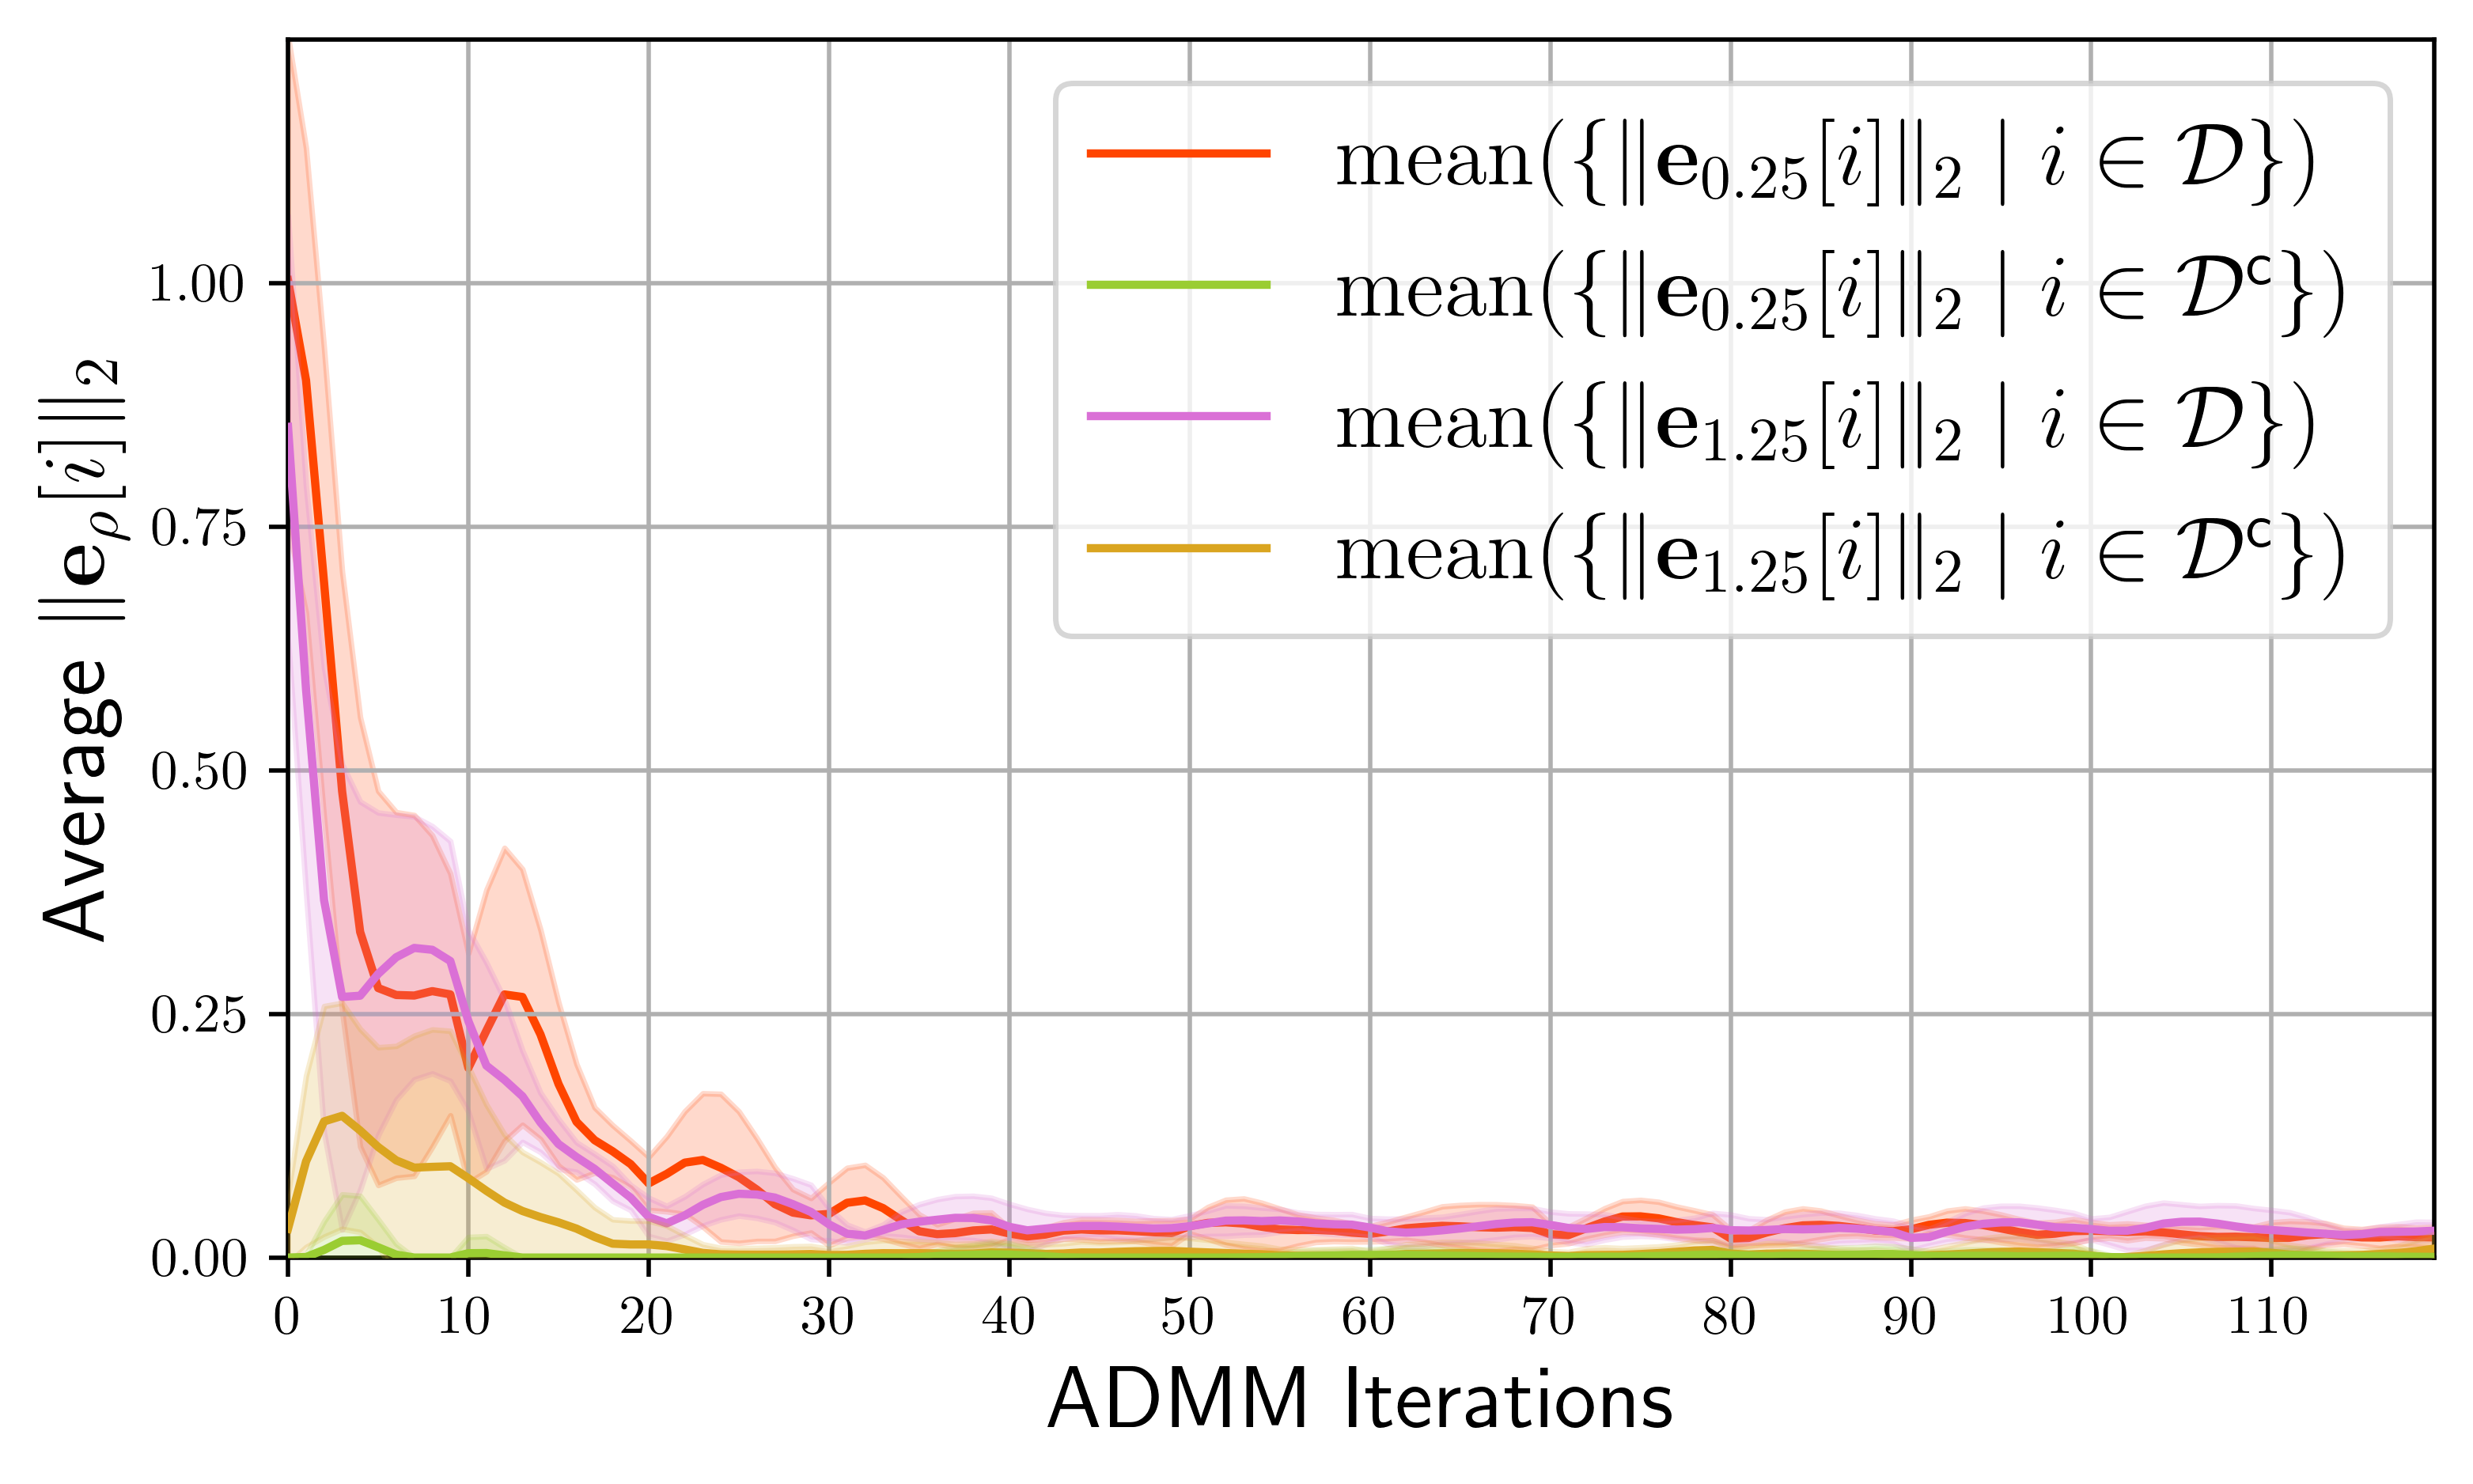

In [57]:
###     Plotting            - Error Convergence

save_err = True
iam_noise = iam_noise_opt[0]
sigma_scale = 1
plt.rcParams.update({
                    'text.usetex': True,
                    # 'font.family': 'Helvetica'
                    })


# Average Agents - LOW RHO
results_low = results_dict[(rho_opt[0], iam_noise)]
x_norm_low = results_low[-1]['x_norm_history']
x_norm_low = [x_norm_low[i].flatten() for i in range(num_agents)]
x_norm_low_nominal = np.zeros((n_iter, 3))
x_norm_low_faulty = np.zeros((n_iter, 3))

for iter in range(n_iter):

    nominal_vals = []
    faulty_vals = []
    for id in range(num_agents):

        if id in faulty_id:
            faulty_vals.append(x_norm_low[id][iter])
        else: 
            nominal_vals.append(x_norm_low[id][iter])
    
    nominal_stdev = stdev(nominal_vals)
    nominal_mean = mean(nominal_vals)
    x_norm_low_nominal[iter, 0] = nominal_mean - sigma_scale*nominal_stdev
    x_norm_low_nominal[iter, 1] = nominal_mean
    x_norm_low_nominal[iter, 2] = nominal_mean + sigma_scale*nominal_stdev

    faulty_stdev = stdev(faulty_vals)
    faulty_mean = mean(faulty_vals)
    x_norm_low_faulty[iter, 0] = faulty_mean - sigma_scale*faulty_stdev
    x_norm_low_faulty[iter, 1] = faulty_mean
    x_norm_low_faulty[iter, 2] = faulty_mean + sigma_scale*faulty_stdev


# Average Agents - HIGH RHO
results_high = results_dict[(rho_opt[1], iam_noise)]
x_norm_high = results_high[-1]['x_norm_history']
x_norm_high = [x_norm_high[i].flatten() for i in range(num_agents)]
x_norm_high_nominal = np.zeros((n_iter, 3))
x_norm_high_faulty = np.zeros((n_iter, 3))

for iter in range(n_iter):

    nominal_vals = []
    faulty_vals = []
    for id in range(num_agents):

        if id in faulty_id:
            faulty_vals.append(x_norm_high[id][iter])
        else: 
            nominal_vals.append(x_norm_high[id][iter])
    
    nominal_stdev = stdev(nominal_vals)
    nominal_mean = mean(nominal_vals)
    x_norm_high_nominal[iter, 0] = nominal_mean - sigma_scale*nominal_stdev
    x_norm_high_nominal[iter, 1] = nominal_mean
    x_norm_high_nominal[iter, 2] = nominal_mean + sigma_scale*nominal_stdev

    faulty_stdev = stdev(faulty_vals)
    faulty_mean = mean(faulty_vals)
    x_norm_high_faulty[iter, 0] = faulty_mean - sigma_scale*faulty_stdev
    x_norm_high_faulty[iter, 1] = faulty_mean
    x_norm_high_faulty[iter, 2] = faulty_mean + sigma_scale*faulty_stdev


# Create Figure
fig_err1 = plt.figure(dpi=500, figsize=(7,4))
ax_err1 = fig_err1.add_subplot()
lines = [None] * 4
areas = [None] * 4


# Low Rho, Faulty
areas[0] = ax_err1.fill_between(np.arange(n_iter), x_norm_low_faulty[:, 0], x_norm_low_faulty[:, 2],
                                alpha=0.2, color='orangered', zorder=0)
lines[0] = ax_err1.plot(np.arange(n_iter), x_norm_low_faulty[:, 1],
                       c='orangered', zorder=1,
                       label=r'$\textnormal{mean}( \{ \| \mathbf{e}_{0.25}[i] \|_2 \mid i \in \mathcal{D} \} )$')

# Low Rho, Nominal
areas[1] = ax_err1.fill_between(np.arange(n_iter), x_norm_low_nominal[:, 0], x_norm_low_nominal[:, 2],
                                alpha=0.2, color='yellowgreen', zorder=7)
lines[1] = ax_err1.plot(np.arange(n_iter), x_norm_low_nominal[:, 1],
                       c='yellowgreen', zorder=6, 
                       label=r'$\textnormal{mean}( \{ \| \mathbf{e}_{0.25}[i] \|_2 \mid i \in \mathcal{D}^\mathsf{c} \} )$')

# High Rho, Faulty
areas[2] = ax_err1.fill_between(np.arange(n_iter), x_norm_high_faulty[:, 0], x_norm_high_faulty[:, 2],
                                alpha=0.2, color='orchid', zorder=2)
lines[2] = ax_err1.plot(np.arange(n_iter), x_norm_high_faulty[:, 1],
                       c='orchid', zorder=3,
                       label=r'$\textnormal{mean}( \{ \| \mathbf{e}_{1.25}[i] \|_2 \mid i \in \mathcal{D} \} )$')

# High Rho, Nominal
areas[3] = ax_err1.fill_between(np.arange(n_iter), x_norm_high_nominal[:, 0], x_norm_high_nominal[:, 2],
                                alpha=0.2, color='goldenrod', zorder=4)
lines[3] = ax_err1.plot(np.arange(n_iter), x_norm_high_nominal[:, 1],
                       c='goldenrod', zorder=5,
                       label=r'$\textnormal{mean}( \{ \| \mathbf{e}_{1.25}[i] \|_2 \mid i \in \mathcal{D}^\mathsf{c} \} )$')


# Figure Settings
ax_err1.set_xlabel(r'ADMM Iterations', fontsize=16)
ax_err1.set_ylabel(r'Average $ \| \mathbf{e}_\rho[i] \|_2 $', fontsize=16)
# ax_err1.set_ylabel(r'$ \| \mathbf{x}[i] - ( \mathbf{x}^* [i] + \hat{\mathbf{x}}[i]) \| $')
ax_err1.set_ylim((0, 1.25))
ax_err1.set_xlim((0, (n_iter - 1)))
ax_err1.set_xticks(ticks=np.arange(0, n_iter, n_admm))
ax_err1.set_yticks(ticks=np.arange(0, 1.25, 0.25))
ax_err1.legend(fontsize=14)
ax_err1.grid(True)


# Save Figure
dt_string = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
fname_err = "final_fig/static/low/compare_err_conv-low_noise-" + dt_string + ".svg"
if save_err:
    plt.savefig(fname_err, dpi=500)
    
# Save Data
fname_err = "data/single_static/compare_err_conv-low_noise-" + dt_string
np.savez(fname_err, x_norm_low_faulty=x_norm_low_faulty, x_norm_low_nominal=x_norm_low_nominal,
                    x_norm_high_faulty=x_norm_high_faulty, x_norm_high_nominal=x_norm_high_nominal)

---
---

---
---

## Simulation: 
###      $\rho = 0.25$
###      iam_noise $= 0.05$

In [ ]:
rho = rho_opt[0]
iam_noise = iam_noise_opt[1]

run_sim(rho, iam_noise, results_dict)

Starting (0.25, 0.05, 1) ...


---


## Simulation: 
###      $\rho = 1.25$
###      iam_noise $= 0.05$

In [31]:
rho = rho_opt[1]
iam_noise = iam_noise_opt[1]

run_sim(rho, iam_noise, results_dict)

Starting (1.25, 0.05, 6) ...


	 -> Solver Error


---

## Compare:
### iam_noise $= 0.05$

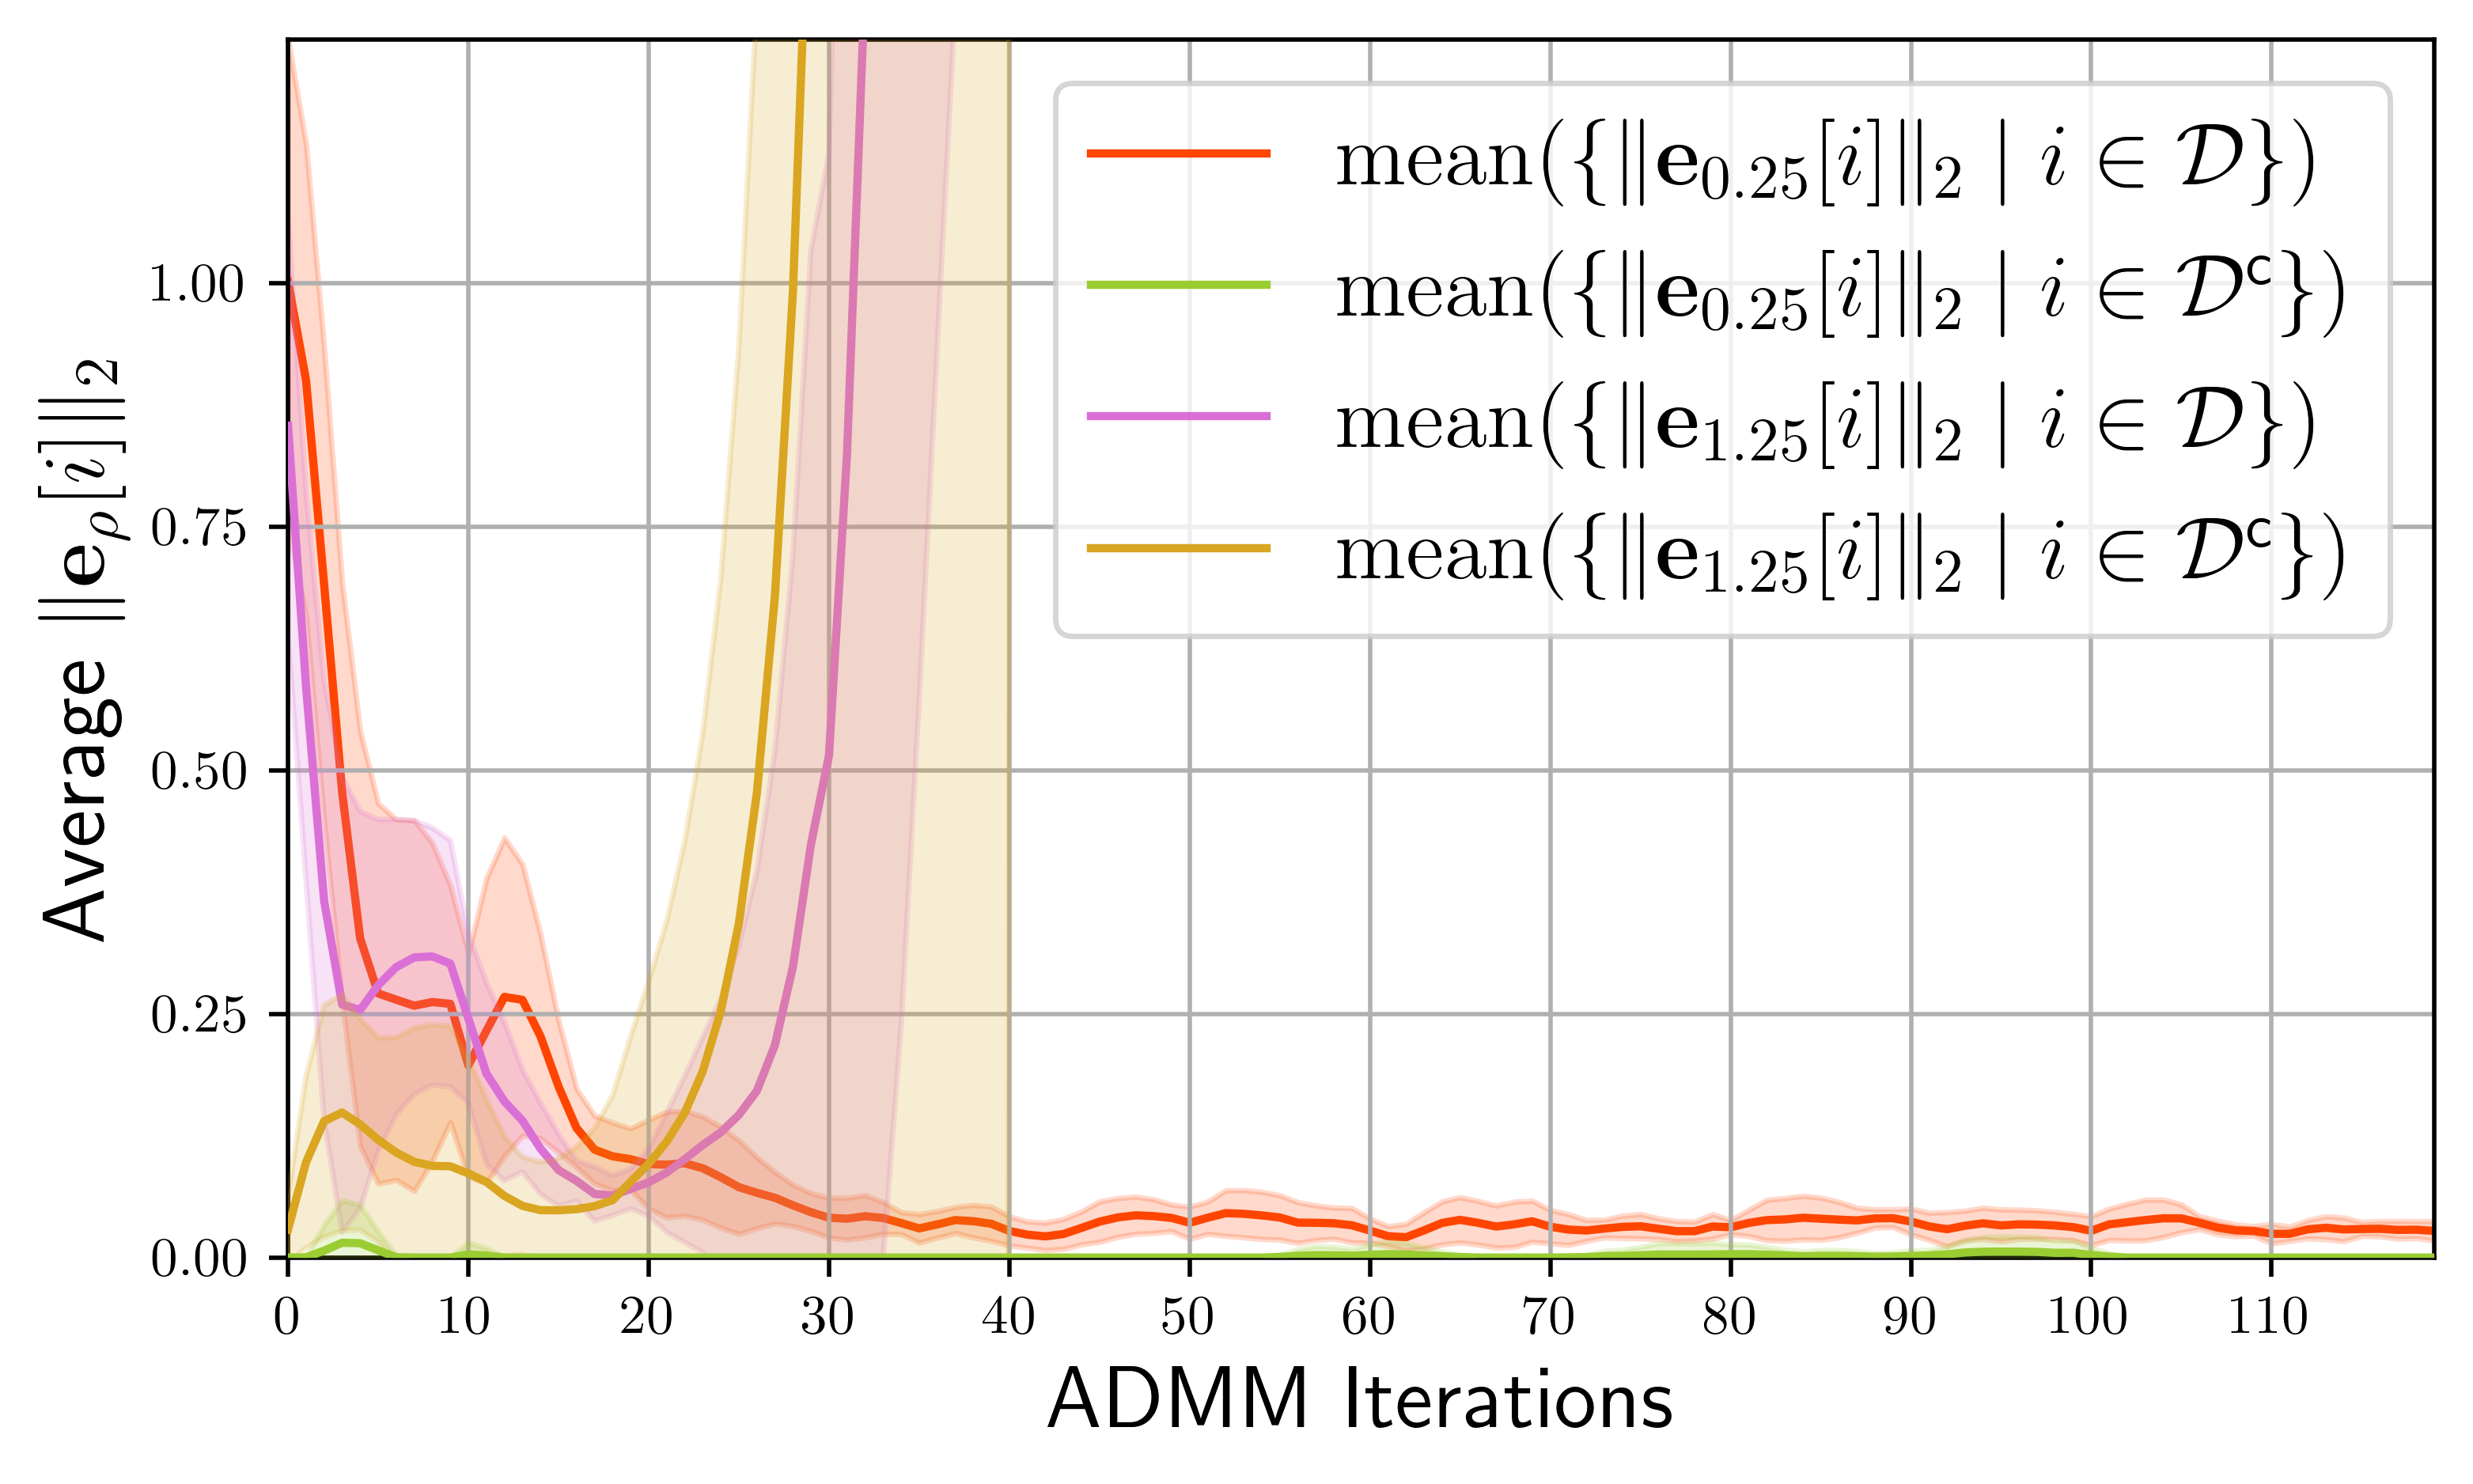

In [58]:
###     Plotting            - Error Convergence

save_err = True
iam_noise = iam_noise_opt[1]
sigma_scale = 1
plt.rcParams.update({
                    'text.usetex': True,
                    # 'font.family': 'Helvetica'
                    })


# Average Agents - LOW RHO
results_low = results_dict[(rho_opt[0], iam_noise)]
x_norm_low = results_low[-1]['x_norm_history']
x_norm_low = [x_norm_low[i].flatten() for i in range(num_agents)]
x_norm_low_nominal = np.zeros((n_iter, 3))
x_norm_low_faulty = np.zeros((n_iter, 3))

for iter in range(n_iter):

    nominal_vals = []
    faulty_vals = []
    for id in range(num_agents):

        if id in faulty_id:
            faulty_vals.append(x_norm_low[id][iter])
        else: 
            nominal_vals.append(x_norm_low[id][iter])
    
    nominal_stdev = stdev(nominal_vals)
    nominal_mean = mean(nominal_vals)
    x_norm_low_nominal[iter, 0] = nominal_mean - sigma_scale*nominal_stdev
    x_norm_low_nominal[iter, 1] = nominal_mean
    x_norm_low_nominal[iter, 2] = nominal_mean + sigma_scale*nominal_stdev

    faulty_stdev = stdev(faulty_vals)
    faulty_mean = mean(faulty_vals)
    x_norm_low_faulty[iter, 0] = faulty_mean - sigma_scale*faulty_stdev
    x_norm_low_faulty[iter, 1] = faulty_mean
    x_norm_low_faulty[iter, 2] = faulty_mean + sigma_scale*faulty_stdev


# Average Agents - HIGH RHO
results_high = results_dict[(rho_opt[1], iam_noise)]
x_norm_high = results_high[-1]['x_norm_history']
x_norm_high = [x_norm_high[i].flatten() for i in range(num_agents)]
x_norm_high_nominal = np.zeros((n_iter, 3))
x_norm_high_faulty = np.zeros((n_iter, 3))

for iter in range(n_iter):

    nominal_vals = []
    faulty_vals = []
    for id in range(num_agents):

        if id in faulty_id:
            faulty_vals.append(x_norm_high[id][iter])
        else: 
            nominal_vals.append(x_norm_high[id][iter])
    
    nominal_stdev = stdev(nominal_vals)
    nominal_mean = mean(nominal_vals)
    x_norm_high_nominal[iter, 0] = nominal_mean - sigma_scale*nominal_stdev
    x_norm_high_nominal[iter, 1] = nominal_mean
    x_norm_high_nominal[iter, 2] = nominal_mean + sigma_scale*nominal_stdev

    faulty_stdev = stdev(faulty_vals)
    faulty_mean = mean(faulty_vals)
    x_norm_high_faulty[iter, 0] = faulty_mean - sigma_scale*faulty_stdev
    x_norm_high_faulty[iter, 1] = faulty_mean
    x_norm_high_faulty[iter, 2] = faulty_mean + sigma_scale*faulty_stdev


# Create Figure
fig_err2 = plt.figure(dpi=500, figsize=(7,4))
ax_err2 = fig_err2.add_subplot()
lines = [None] * 4
areas = [None] * 2
fail_point = 41


# Low Rho, Faulty
ax_err2.fill_between(np.arange(n_iter), x_norm_low_faulty[:, 0], x_norm_low_faulty[:, 2],
                    alpha=0.2, color='orangered', zorder=0)
lines[0] = ax_err2.plot(np.arange(n_iter), x_norm_low_faulty[:, 1],
                       c='orangered', zorder=1,
                       label=r'$\textnormal{mean}( \{ \| \mathbf{e}_{0.25}[i] \|_2 \mid i \in \mathcal{D} \} )$')

# Low Rho, Nominal
ax_err2.fill_between(np.arange(n_iter), x_norm_low_nominal[:, 0], x_norm_low_nominal[:, 2],
                    alpha=0.2, color='yellowgreen', zorder=7)
lines[1] = ax_err2.plot(np.arange(n_iter), x_norm_low_nominal[:, 1],
                       c='yellowgreen', zorder=6, 
                       label=r'$\textnormal{mean}( \{ \| \mathbf{e}_{0.25}[i] \|_2 \mid i \in \mathcal{D}^\mathsf{c} \} )$')

# High Rho, Faulty
ax_err2.fill_between(np.arange(n_iter)[:fail_point], x_norm_high_faulty[:fail_point, 0], x_norm_high_faulty[:fail_point, 2],
                    alpha=0.2, color='orchid', zorder=2)
lines[2] = ax_err2.plot(np.arange(n_iter)[:fail_point], x_norm_high_faulty[:fail_point, 1],
                       c='orchid', zorder=3,
                       label=r'$\textnormal{mean}( \{ \| \mathbf{e}_{1.25}[i] \|_2 \mid i \in \mathcal{D} \} )$')

# High Rho, Nominal
ax_err2.fill_between(np.arange(n_iter)[:fail_point], x_norm_high_nominal[:fail_point, 0], x_norm_high_nominal[:fail_point, 2],
                    alpha=0.2, color='goldenrod', zorder=4)
lines[3] = ax_err2.plot(np.arange(n_iter)[:fail_point], x_norm_high_nominal[:fail_point, 1],
                       c='goldenrod', zorder=5,
                       label=r'$\textnormal{mean}( \{ \| \mathbf{e}_{1.25}[i] \|_2 \mid i \in \mathcal{D}^\mathsf{c} \} )$')


# Figure Settings
ax_err2.set_xlabel(r'ADMM Iterations', fontsize=16)
ax_err2.set_ylabel(r'Average $ \| \mathbf{e}_\rho[i] \|_2 $', fontsize=16)
# ax_err2.set_ylabel(r'$ \| \mathbf{x}[i] - ( \mathbf{x}^* [i] + \hat{\mathbf{x}}[i]) \| $')
ax_err2.set_ylim((0, 1.25))
ax_err2.set_xlim((0, (n_iter - 1)))
ax_err2.set_xticks(ticks=np.arange(0, n_iter, n_admm))
ax_err2.set_yticks(ticks=np.arange(0, 1.25, 0.25))
ax_err2.legend(fontsize=14)
ax_err2.grid(True)


# Save Figure
dt_string = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
fname_err = "final_fig/static/high/compare_err_conv-high_noise-" + dt_string + ".svg"
if save_err:
    plt.savefig(fname_err, dpi=500)

# Save Data
fname_err = "data/single_static/compare_err_conv-high_noise-" + dt_string
np.savez(fname_err, x_norm_low_faulty=x_norm_low_faulty, x_norm_low_nominal=x_norm_low_nominal,
                    x_norm_high_faulty=x_norm_high_faulty, x_norm_high_nominal=x_norm_high_nominal)